In [1]:
import pandas as pd
import pysam
import numpy as np
import akita_utils
import h5py
import time

import matplotlib.pyplot as plt
import seaborn as sns

from akita_utils.utils import ut_dense
from akita_utils.stats_utils import get_reference_map_matrix, get_map_matrix, plot_map, calculate_scores, calculate_SCD

In [6]:
out_dir = "/scratch2/smaruj/BIGTEST_dots"
name = "MAPS_OUT.h5"
# name = "STATS_OUT.h5"

In [7]:
job_h5_file = f"{out_dir}/{name}"

In [8]:
job_h5_open = h5py.File(job_h5_file, "r")

In [9]:
for key in job_h5_open:
    print(key, job_h5_open[key].shape)

background_index (540,)
boundary_end (540,)
boundary_index (540,)
boundary_start (540,)
chrom (540,)
end (540,)
exp_id (540,)
flank_bp (540,)
map_h1_m1 (540, 130305, 6)
num_ctcf (540,)
orientation (540,)
refmap_h1_m1 (10, 130305, 6)
seq_id (540,)
spacer_bp (540,)
span (540,)
start (540,)
strand (540,)


In [10]:
job_h5_open["SCD_h1_m1_t5"][:15]

KeyError: "Unable to open object (object 'SCD_h1_m1_t5' doesn't exist)"

In [11]:
job_h5_open["SCD_h1_m1_t5"][378]

KeyError: "Unable to open object (object 'SCD_h1_m1_t5' doesn't exist)"

In [12]:
num_experiments = len(job_h5_open["seq_id"])

In [13]:
# getting reference matrix
reference = get_reference_map_matrix(job_h5_open, head_index=1, model_index=1, num_background=10)

In [14]:
maps = get_map_matrix(job_h5_open, head_index=1, model_index=1, num_experiments=num_experiments)

In [15]:
maps.shape

(540, 512, 512, 6)

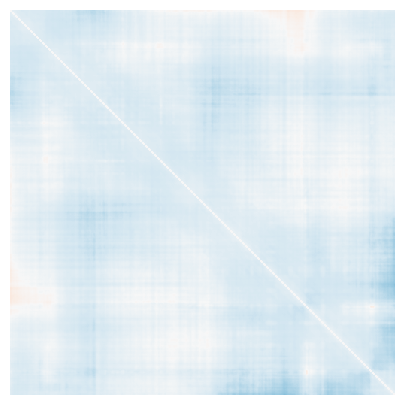

In [16]:
plot_map(maps[500,:,:,0])

In [ ]:
stat_metrics = ["SCD"]

In [ ]:
nr_targets = 6

In [ ]:
calculate_SCD(reference[0,:,:,0])

In [ ]:
boSCD = np.zeros((num_experiments, nr_targets))

In [ ]:
for exp_index in range(num_experiments):
    
    exp_map = maps[exp_index,:,:]
    # plot_map(exp_map[:,:,0])
    bg_index = job_h5_open["background_index"][exp_index]
    ref_map = reference[bg_index,:,:]

    boSCD[exp_index,: ] += calculate_SCD(exp_map, ref_map)

In [ ]:
np.save(f"/scratch2/smaruj/TEST_boundaries/scd.npy", boSCD)

In [ ]:
job_h5_open.close()

In [ ]:
# dot scores

In [ ]:
job_h5_file = f"/scratch2/smaruj/TEST_dots/{name}"

In [ ]:
job_h5_open = h5py.File(job_h5_file, "r")

In [ ]:
reference = get_reference_map_matrix(job_h5_open, head_index=1, model_index=1, num_background=10)

In [ ]:
maps = get_map_matrix(job_h5_open, head_index=1, model_index=1, num_experiments=num_experiments)

In [ ]:
stat_metrics = ["SCD", "dot-score", "cross-score", "x-score"]

In [ ]:
SCD = np.zeros((num_experiments, nr_targets))
dots = np.zeros((num_experiments, nr_targets))
x_score = np.zeros((num_experiments, nr_targets))
cross_score = np.zeros((num_experiments, nr_targets))

In [ ]:
for exp_index in range(num_experiments):
    
    exp_map = maps[exp_index,:,:]
    # plot_map(exp_map[:,:,0])
    bg_index = job_h5_open["background_index"][exp_index]
    ref_map = reference[bg_index,:,:]

    scores = calculate_scores(stat_metrics, exp_map, ref_map)
    SCD[exp_index,: ] += scores["SCD"]
    dots[exp_index,: ] += scores["dot-score"]
    x_score[exp_index,: ] += scores["x-score"]
    cross_score[exp_index,: ] += scores["cross-score"]

In [ ]:
np.save(f"/scratch2/smaruj/TEST_boundaries/dot_scores_SCD.npy", SCD)
np.save(f"/scratch2/smaruj/TEST_boundaries/dot_scores_dot.npy", dots)
np.save(f"/scratch2/smaruj/TEST_boundaries/dot_scores_x.npy", x_score)
np.save(f"/scratch2/smaruj/TEST_boundaries/dot_scores_cross.npy", cross_score)

In [ ]:
big_df = pd.read_table("./ctcf_tsv/filtered_base_mouse_ctcf_scores.tsv", sep="\t")

In [ ]:
boundary_SCD = np.mean(SCD[:54,:], axis=1)

In [ ]:
dot_cross = np.mean(cross_score[:54,:], axis=1)

In [ ]:
big_df.columns

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

# Axes.scatter(x, y,...)
scatter = ax.scatter(big_df["boSCD_avg"], big_df["cross_avg"], alpha=0.7)
scatter = ax.scatter(boundary_SCD, dot_cross, alpha=0.7)

# pearson_corr = stats.pearsonr(big_df["boSCD_avg"], big_df["dotSCD_avg"]).statistic
# rounded_pearson_corr = round(pearson_corr, 3)

ax.set_xlabel("boundary SCD")
ax.set_ylabel("dot SCD")

# ax.set_title(f"Correlation between boundary SCD and dot SCD; Pearson Correlation = {rounded_pearson_corr}")

# plt.savefig("./plots/boundarySCD_vs_dotSCD.png", bbox_inches="tight")

plt.show()